<center>
<img src="../../img/ods_stickers.jpg">
## <center>Открытый курс по машинному обучению
<center> Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий



# <center>Домашнее задание 7. <br> Метод главных компонент, t-SNE и кластеризация</center>

В этой домашней работе мы  попрактикуемся в снижении размерности, визуализации и кластеризации данных, встроенных в `sklearn`. Ответы на вопросы заполните в [веб-форме](https://docs.google.com/forms/d/e/1FAIpQLSdjgje8qvptEW1EKY-QBbHXmXGIs6QYK2PqhchzF4Kpg3v8OQ/viewform?usp=sf_link).

## 1. PCA

Начнём с того, что импортируем все необходимые модули

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='white')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.model_selection import train_test_split

Дана игрушечная выборка. 

In [2]:
X = np.array([[2., 13.], [1., 3.], [6., 19.],
              [7., 18.], [5., 17.], [4., 9.],
              [5., 22.], [6., 11.], [8., 25.]])

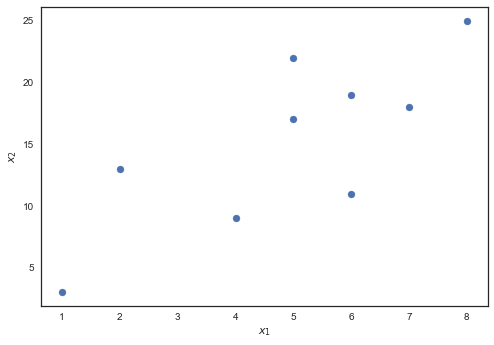

In [3]:
plt.scatter(X[:,0], X[:, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$');

<font color='red'>Вопрос 1. </font>На сколько градусов относительно оси $x_1$ повернут вектор, задающий 1 главную компоненту в этих данных (на забудьте отмасштабировать выборку при помощи StandardScaler)? 
- 30 градусов
- 45 градусов
- 60 градусов
- 75 градусов

In [4]:
X_df=pd.DataFrame(X)
scaler=StandardScaler()
scaler.fit(X_df)
X_sc=pd.DataFrame(scaler.transform(X_df))
X_sc

,0,1
0,-1.355344,-0.343098
1,-1.824501,-1.887040
2,0.521286,0.583267
3,0.990443,0.428873
4,0.052129,0.274478
5,-0.417029,-0.960675
6,0.052129,1.046449
7,0.521286,-0.651886
8,1.459601,1.509632


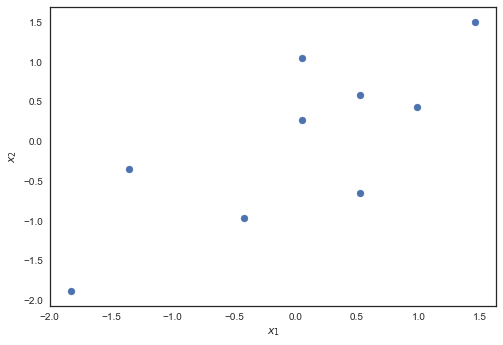

In [5]:
plt.scatter(X_sc[0], X_sc[1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$');

<font color='red'>Вопрос 2. </font> Каковы собственные значения матрицы $X^TX$, где $X$ – матрица, соответствующая отмасштабированной выборке? 

 - 4 и 1.42
 - 16.2 и 2702.8
 - 4.02 и 51.99
 - 15.97 и 2.03

In [6]:
X_sc.T.dot(X_sc)

,0,1
0,9.000000,6.969872
1,6.969872,9.000000


In [7]:
np.linalg.eig(X_sc.T.dot(X_sc))[1]

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [8]:
np.linalg.eig(X_sc.T.dot(X_sc))[0]

array([ 15.96987204,   2.03012796])

In [9]:
from scipy.linalg import svd
U, Sigma, VT = svd(X_sc)

In [10]:
Sigma

array([ 3.99623223,  1.42482559])

<font color='red'>Вопрос 3. </font> В чем смысл двух чисел из прошлого вопроса? 

- их квадраты говорят о том, какую часть дисперсии исходных данных объясняют главные компоненты
- они задают угол, на который 1-я главная компонента повернута относительно исходных координат
- эти числа говорят о том, какую часть дисперсии исходных данных объясняют главные компоненты
- корни из этих чисел задают угол, на который 1-я главная компонента повернута относительно исходных координат

Загрузим датасет с лицами людей и выведем имена этих людей (это должно делаться при подключении к Интернету, причем нужно неплохое соединение, не как в метро).

In [11]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, 
                resize=0.4, data_home='../../data/faces')

print('%d objects, %d features, %d classes' % (lfw_people.data.shape[0],
      lfw_people.data.shape[1], len(lfw_people.target_names)))
print('\nPersons:')
for name in lfw_people.target_names:
    print(name)

1560 objects, 1850 features, 12 classes

Persons:
Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Jacques Chirac
Jean Chretien
John Ashcroft
Junichiro Koizumi
Serena Williams
Tony Blair


Посмотрим на содержимое датасета. Все изображения лежат в массиве lfw_people.images

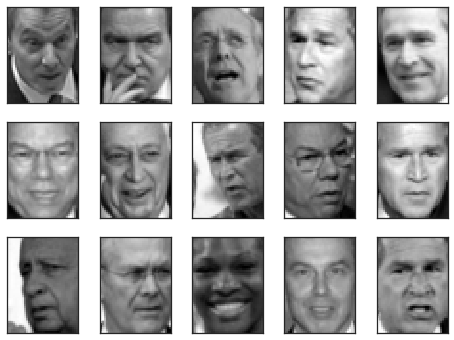

In [13]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='gray')

In [14]:
n_samples, h, w = lfw_people.images.shape
print (n_samples, h, w)

1560 50 37


In [15]:
df1=pd.DataFrame(lfw_people.data)
#df1 = pd.DataFrame.from_records(lfw_people.images.flatten())

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Columns: 1850 entries, 0 to 1849
dtypes: float32(1850)
memory usage: 11.0 MB


<font color='red'>Вопрос 4. </font>Какое **минимальное** число компонент PCA необходимо, чтобы объяснить 90% дисперсии масштабированных (при помощи StandardScaler) данных?

- 75
- 76
- 77
- 78

Для PCA в данной задаче стоит использовать параметр [`svd_solver='randomized'`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), который является приближением PCA, но позволяет существенно ускорить его работу на больших наборах данных. Для того, чтобы результаты можно было сравнивать, нужно зафиксировать `random_state=1`.

In [17]:
scaler1=StandardScaler()
scaler1.fit(lfw_people.data)
X_sc1=scaler1.transform(lfw_people.data)
pca = PCA(svd_solver='randomized',random_state=1)

X_reduced = pca.fit_transform(X_sc1)
print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())

[  4.96171025e+02   2.62523626e+02   1.32368489e+02 ...,   2.45515458e-05
   2.42637244e-05   8.54333188e-36]
[  2.68200548e-01   1.41904659e-01   7.15505328e-02 ...,   1.32711056e-08
   1.31155264e-08   4.61801713e-39]
[ 0.26820055  0.41010521  0.48165574 ...,  0.99999999  1.          1.        ]


In [18]:
print (75,pca.explained_variance_ratio_.cumsum()[75])
print (76,pca.explained_variance_ratio_.cumsum()[76])
print (77,pca.explained_variance_ratio_.cumsum()[77])
print (78,pca.explained_variance_ratio_.cumsum()[78])

75 0.899089469224
76 0.900266955397
77 0.901431294912
78 0.902592423559


In [22]:
pca1 = PCA(n_components=30,svd_solver='randomized',random_state=1)
X_reduced1 = pca1.fit_transform(X_sc1)
eigenfaces = pca1.components_.reshape((30,50,37))
#eigenfaces = pca.components_.reshape((n_components, h, w))

In [23]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

In [24]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=15)
        plt.xticks(())
        plt.yticks(())


Постройте картинку, на которой изображены первые 30 главных компонент (только не пугайтесь, когда увидите, что получилось). Для этого надо эти 30 векторов взять из `pca.components_`, трансформировать опять по размеру исходных изображений (50 x 37) и нарисовать.

IndexError: index 12 is out of bounds for axis 0 with size 12

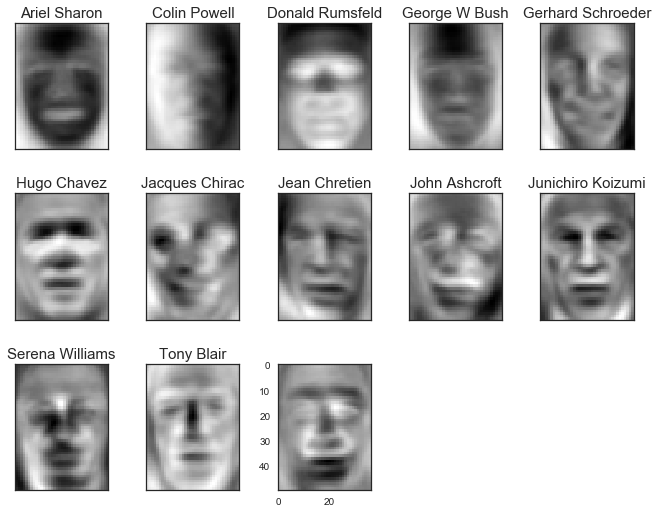

In [26]:
plot_gallery(eigenfaces,lfw_people.target_names, h, w, n_row=3, n_col=5)

<font color='red'>Вопрос 5. </font> Какая из первых 30 главных компонент сильнее всего "отвечает" за освещенность лица слева? Конкретней: для какой главной компоненты линейная комбинация исходных признаков (интенсивностей пикселов), если ее представить как изображение, выглядит, как фотография, ярко освещенная слева.

- 1
- 2
- 4
- 5

Теперь давайте построим проекцию лиц в пространство главных компонент с числом компонент равным 2.

<font color='red'>Вопрос 6. </font> Кто меньше всего похож на других людей в выборке, если выделять 2 главные компоненты? Для ответа на этот вопрос выделите 2 главные компоненты в масштабированных данных (используйте опять  параметр `svd_solver='randomized'` и `random_state=1`), посчитайте для каждого человека в выборке среднее значение 2 главных компонент всех его фотографий, затем из 12 2-мерных точек найдите наиболее удаленную от остальных (по среднему евклидову расстоянию до других точек). Можно это делать точно, а можно и на глаз с помощью `sklearn.metrics.euclidean_distances` и `seaborn.heatmap`.

- Колин Пауэлл
- Джордж Буш
- Жак Ширак
- Серена Уильямс

In [31]:
pca2 = PCA(n_components=2,svd_solver='randomized',random_state=1)
X_reduced1 = pca2.fit_transform(X_sc1)
eigenfaces1 = pca2.components_.reshape((2,50,37))

IndexError: index 2 is out of bounds for axis 0 with size 2

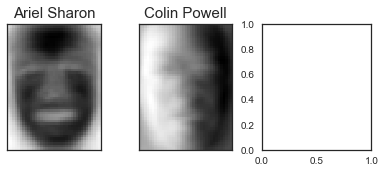

In [32]:
plot_gallery(eigenfaces1,lfw_people.target_names, h, w, n_row=3, n_col=5)

## 2. t-SNE

Возьмём упомянутый в статье способ визуализации данных с помощью [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) и посмотрим на наши лица на плоскости. При использовании `n_components=2` и `random_state=1` в левом верхнем углу проекции образуется кластер из лиц, относящихся к одному человеку. 

<font color='red'>Вопрос 7. </font> Какому человеку из набора данных lfw_people соответствуют два выброса в правом верхнем углу проекции t-SNE с параметрами `n_components=2` и `random_state=1`?

- Серена Уильямс
- Уго Чавес
- Джордж Буш
- Жак Ширак

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

## 3. Кластеризация

Для следующего вопроса загрузим набор данных с ценами на жильё:

In [33]:
boston = datasets.load_boston()
X = boston.data

In [34]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

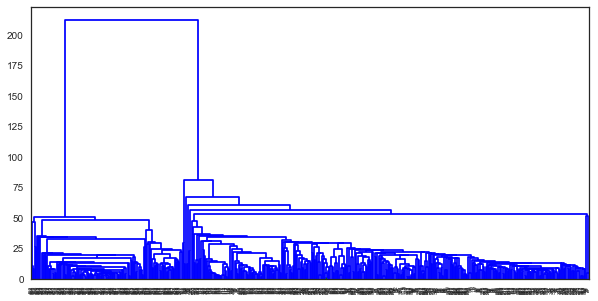

In [35]:
distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

Найдем с помощью метода локтя (см. 7 [статью](https://habrahabr.ru/company/ods/blog/325654/) курса) оптимальное число кластеров, которое стоит задать алгоритму kMeans в качестве гиперпараметра. 

In [37]:
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster,random_state=1).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.6913981188326788
For n_clusters=3, The Silhouette Coefficient is 0.7234030341612716
For n_clusters=4, The Silhouette Coefficient is 0.5682191708534291
For n_clusters=5, The Silhouette Coefficient is 0.5707386655129686
For n_clusters=6, The Silhouette Coefficient is 0.5012589305065804
For n_clusters=7, The Silhouette Coefficient is 0.5082741324198952
For n_clusters=8, The Silhouette Coefficient is 0.4622989412538708
For n_clusters=9, The Silhouette Coefficient is 0.47309876223192215
For n_clusters=10, The Silhouette Coefficient is 0.46108662040818793


<font color='red'>Вопрос 8. </font> Каким будет оптимальное число кластеров для датасета с ценами на жильё, если оценивать его с помощью метода локтя? Используйте в kMeans `random_state=1`, данные не масштабируйте.

- 2
- 3
- 4
- 5

В данном случае мы ищем наиболее выделеный излом в кривой расстояний до цетроидов в зависимости от числа кластеров. Будем рассматривать возможное число кластеров от 2 до 10. Как и в предыдущей задаче, нужно будет использовать `random_state=1` для инициализации алгоритма k-means.

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

Вернемся к набору данных с лицами. Притворимся, что мы не знаем ответов – на какой фотографии кто изображен, но знаем, что это 12 разных людей. Давайте сравним результаты кластеризации фотографий с помощью 4 алгоритмов – KMeans, агломеративной кластеризации, AffinityPropagation и спектральной кластеризации. Параметры алгоритмов возьмите как в примере в конце [статьи](https://habrahabr.ru/company/ods/blog/325654/), только измените число кластеров на 12.

In [38]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

algorithms = []
algorithms.append(KMeans(n_clusters=12, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=12, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=12))
y=lfw_people.target
data = []
for algo in algorithms:
    algo.fit(X_sc1)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(X_sc1, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.027093,0.068304,0.095802,0.083819,0.089410,0.044945
Affinity,0.014616,0.086747,0.305615,0.154552,0.205288,0.019190
Spectral,0.011699,0.067703,0.086099,0.094563,0.090133,-0.050495
Agglomerative,0.027382,0.073197,0.099838,0.089044,0.094132,0.025744


<font color='red'>Вопрос 9. </font> Выберите все верные утверждения:

- Агломеративная кластеризация справилась лучше всех других алгоритмов по всем метрикам качества
- Результаты кластеризации неудовлетворительные, ни одна из метрики не превышает 35%
- Affinity Propagation сработала лучше спектральной кластеризации по всем метрикам качества
- Если выделять только 2 кластера, а результаты кластеризации сравнивать с бинарным вектором, Серена Уильямс это или нет, то в целом алгоритмы справляются лучше, некоторые метрики превышают значение в 66%

Возьмите полученные раннее координаты 12 "средних" изображений людей. Постройте для них дендрограмму. Используйте  `scipy.cluster.hierarchy` и `scipy.spatial.distance.pdist`, параметры возьмите такие же, как в соответствующем примере в [статье](https://habrahabr.ru/company/ods/blog/325654/).

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

''' ВАШ КОД ЗДЕСЬ '''

<font color='red'>Вопрос 10. </font> Какому человеку соответствует точка, объединившаяся с другими при построении дендрограммы **предпоследней**?

- Gerhard Schroeder
- Jean Chretien
- John Ashcroft
- Junichiro Koizumi